# Maximum Entropy Approximation - mRNA

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [5]:
import glob
import pickle
import dill
# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate
import mpmath
# Import liibrary to perform maximum entropy fits
from maxentropy.skmaxent import FeatureTransformer, MinDivergenceModel

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'

### $\LaTeX$ macros

$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{avg}[1]{\left\langle #1 \right\rangle}$

# The MaxEnt approximation.

Given the difficulty at solving chemical master equations (CME) there is an extensive repertoire of approximate methods to tackle the problem of solving these equations. A particularly interesting method uses the so-called moment-expansion and maximum entropy approach to approximate distributions given knowledge of some of the moments of the distribution.

In particular given a distribution $P_X(x)$, the $n^{\text{th}}$ moment of the distribution for a discrete set of possible values of $x$ is given by
$$
\avg{x^n} \equiv \sum_x x^n P_X(x).
$$

Now assume that we have knowledge of the first $m$ moments. The question is can we use this information to build an estimator $P_H(x \mid m)$ of the distribution such that
$$
\lim_{m \rightarrow \infty} P_H(x \mid m) \rightarrow P_X(x),
$$
i.e. that the more moments we add to our approximation, the more the estimator distribution converges to the real distribution.

For this we use the principle of maximum entropy in which our best guess for this estimator is built on the base of maximizing the Shannon entropy constrained by the limited information that we have. The maximization of the Shannon entropy guarantees that we are less committed to information that we do not posses. The Shannon entropy for a single variable discrete distribution is given by
$$
H(x) \equiv - \sum_x P_X(x) \log P_X(x).
$$

Given the knowledge of the first $m$ moments we define the Lagrangian $\mathcal{L}(x)$ to be maximized as
$$
\mathcal{L}(x) \equiv H(x) - \sum_{i=0}^m 
\left[ \lambda_i \left( \avg{x^i} - \sum_x x^i P_X(x) \right) \right],
$$
where $\lambda_i$ is the Lagrange multiplier associated with the $i^{\text{th}}$ moment.

To find the best guess for the estimator distribution we solve the constrained optimization problem. Setting the variational derivative of the Lagrangian with respect to $P_X(X)$ gives
$$
{\delta \mathcal{L} \over \delta P_X(x)} = -\log P_X(X) - 1 - 
\sum_{i=0}^m \lambda_i \avg{x^i}.
$$

Setting this derivative to zero and solving for the distribution (that we now start calling $P_H(x)$, our MaxEnt estimator) gives
$$
P_H(x) = \exp \left(- 1 - \sum_{i=0}^m \lambda_i \avg{x^i}  \right)
={1 \over \mathcal{Z}}  \exp \left( - \sum_{i=1}^m \lambda_i \avg{x^i}  \right),
$$
where $\mathcal{Z}$ is the normalization constant given by 
$$
\mathcal{Z} \equiv \exp\left( 1 + \lambda_0 \right) = 
\sum_x \exp \left( - \sum_{i=1}^m \lambda_i \avg{x^i}  \right)
$$

## Numerically estimating the probability distribution.

Given that we have a theoretical expectation of what the moments of the distribution are, we can use this approximation to generate an estimate for the entire distribution. The only limiting step is to numerically determine the value of the Lagrange multipliers $\lambda_i$.

Instead of directly estimating the distribution we will use the `maxentropy` package in Python to perform the fit.

In the following example we will fit the classic example of an unfair die with a mean value of $\avg{x} = 4.5$ as done in [this notebook](https://github.com/PythonCharmers/maxentropy/blob/master/notebooks/Loaded%20die%20example%20-%20skmaxent.ipynb).

In [60]:
# Fit a model p(x) for dice probabilities (x=1,...,6) with the
# single constraint E(X) = 4.5
def first_moment_die(x):
    return np.array(x)

# Put the constraint functions into an array
features = [first_moment_die]
# Write down the constraints (in this case mean of 4.5)
k = np.array([4.5])

# Define the sample space of the die (from 1 to 6)
samplespace = list(range(1, 7))

# Define the minimum entropy 
model = MinDivergenceModel(features, samplespace)

# Change the dimensionality of the array
X = np.atleast_2d(k)
# Fit the model
model.fit(X)

MinDivergenceModel(algorithm='CG',
          features=[<function first_moment_die at 0x1a13d227b8>],
          matrix_format='csr_matrix', prior_log_probs=None,
          samplespace=[1, 2, 3, 4, 5, 6], vectorized=True, verbose=0)

Let's look at the resulting distribution

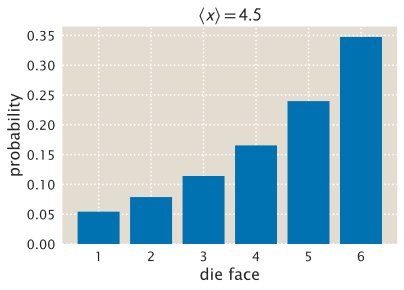

In [62]:
plt.bar(samplespace, model.probdist())
plt.xlabel('die face')
plt.ylabel('probability')
_ = plt.title(r'$\left\langle x \right\rangle = 4.5$')

Just for curiosity let's see how long it takes to perform this simple fit for the algorithm.

In [63]:
# Fit the model
%timeit model.fit(X)

322 µs ± 6.25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Import `lambdify` functions using `dill`.

When the analytical results were derived we generated `lambdify` functions to explore these results numerically and export them into a file using the `dill` library. Let's now import these functions into this notebook to make use of them. 

In [64]:
# Import two-state mRNA moments
# Parameters are feed in the following order:
# (kp_on, kp_off, rm, gm)
with open(tmpdir + 'two_state_mRNA_lambdify.dill', 'rb') as file:
    first_unreg_m = dill.load(file)
    second_unreg_m = dill.load(file)
    third_unreg_m = dill.load(file)
    
# Import two-state mRNA moments
# Parameters are feed in the following order:
# (kr_on, kr_off, kp_on, kp_off, rm, gm)
with open(tmpdir + 'three_state_mRNA_lambdify.dill', 'rb') as file:
    first_reg_m = dill.load(file)
    second_reg_m = dill.load(file)
    third_reg_m = dill.load(file)

## Fit unregulated promoter.

As an exercise to test the performance of this approximation let's fit the Maximum entropy model to the two-state unregulated promoter model. For this we have previously determined the model parameters from experimental data, and there is a closed-form solution for the CME, given the chance to compare the performance of this algorithm.

Let's first define the three functions needed to implement the first three moment constraints.

In [83]:
def first(x):
    return np.array(x)

def second(x):
    return np.array(x)**2

def third(x):
    return np.array(x)**3

Now let's define the parameters for the *lacUV5* unregulated promoter.

In [84]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1)

We can now use the `maxnetropy` package to fit the maximum entropy model

In [95]:
# Put the constraint functions into an array
features = [first, second, third]
# Write down the constraints (in this case mean of 4.5)
m1, m2, m3 = first_unreg_m(*par_UV5.values()), \
             second_unreg_m(*par_UV5.values()),\
             third_unreg_m(*par_UV5.values())

constraints = np.array([m1, m2, m3])

# Define the sample space for the truncated mRNA dist
samplespace = list(range(0, 1000))

# Define the minimum entropy 
model = MinDivergenceModel(features, samplespace)

# Change the dimensionality of the array
X = np.reshape(constraints, (1, -1))
# # Fit the model
model.fit(X)

MinDivergenceModel(algorithm='CG',
          features=[<function first at 0x1a19b96158>, <function second at 0x1a19b961e0>, <function third at 0x1a19b96730>],
          matrix_format='csr_matrix', prior_log_probs=None,
          samplespace=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 7... 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
          vectorized=True, verbose=0)

(0, 50)

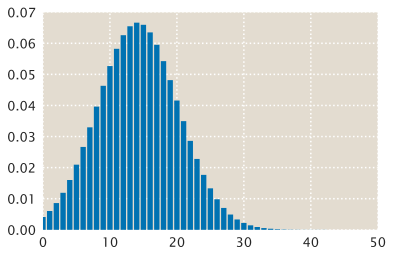

In [97]:
plt.bar(samplespace, model.probdist())
plt.xlim(0, 50)

Let's now define the function to compute the analytical form of the distribution

In [28]:
# define a np.frompyfunc that allows us to evaluate the sympy.mp.math.hyp1f1
np_log_hyp= np.frompyfunc(lambda x, y, z: \
mpmath.ln(mpmath.hyp1f1(x, y, z, zeroprec=1000)), 3, 1)

def log_p_m_unreg(mRNA, kp_on, kp_off, gm, rm):
    '''
    Computes the log probability lnP(m) for an unregulated promoter, 
    i.e. the probability of having m mRNA.
    
    Parameters
    ----------
    mRNA : float.
        mRNA copy number at which evaluate the probability.        
    kp_on : float.
        rate of activation of the promoter in the chemical master equation
    kp_off : float.
        rate of deactivation of the promoter in the chemical master equation
    gm : float.
        1 / half-life time for the mRNA.
    rm : float.
        production rate of the mRNA
    
    Returns
    -------
    log probability lnP(m)
    '''
    # Convert the mRNA copy number to a  numpy array
    mRNA = np.array(mRNA)
    
    # Compute the probability
    lnp = scipy.special.gammaln(kp_on / gm + mRNA) \
    - scipy.special.gammaln(mRNA + 1) \
    - scipy.special.gammaln((kp_off + kp_on) / gm + mRNA) \
    + scipy.special.gammaln((kp_off + kp_on) / gm) \
    - scipy.special.gammaln(kp_on / gm) \
    + mRNA * np.log(rm / gm) \
    + np_log_hyp(kp_on / gm + mRNA,
            (kp_off + kp_on) / gm + mRNA, -rm / gm)
    
    return lnp.astype(float)

## Integrating the number of repressors into the picture

The way that the repressor copy number enters the kinetic scheme is by assuming that the $\kron$ rate is a diffusion limited rate of the form
$$
\kron = k_o \left[ R \right].
$$
The constant $k_o$ was indirectly inferred by the Sunney Xie lab and quoted by Jones and Brewster as $k_o = 2.7 \times 10^{-3} (\text{s nM})^{-1}$.

The value of $\kroff$ is then constrained by the value of the binding energy as inferred using equilibrium statistical mechanics. For the stat. mech. framework we have that the fold-change in gene expression is given by
$$
\foldchange = \frac{1}{1 + \frac{R \cdot p_{act}}{N_{NS}} e^{-\beta \Delta \epsilon_r}},
$$
where $R$ is the absolute copy number of repressors per cell, $N_{NS}$ is the number of non-specific binding sites for the repressors (in our case the entire *E. coli genome* $4.6 \times 10^6$), $\beta$ is the inverse temperature times the Boltzmann constant and $\Delta \epsilon_r$ is the binding energy of the repressor to the operator binding site.

In the case of the three-state promoter the fold-change is given by
$$
\foldchange = {1 \over 1 + {\kron \over \kroff} 
               \left( {\kpoff \over \kpoff + \kpon} \right)}
            = {1 \over 1 + {k_o [R] p_{act} \over \kroff} 
               \left( {\kpoff \over \kpoff + \kpon} \right)}.
$$

Given that these two equation have the same functional form we can conclude that
$$
\frac{R \cdot p_{act}}{N_{NS}} e^{-\beta \Delta \epsilon_r} =
{k_o [R] p_{act} \over \kroff} 
               \left( {\kpoff \over \kpoff + \kpon} \right).
$$
If we solve for $\kroff$ and convert the absolute number or repressors $R$ into a concentration $[R]$ we find that
$$
\kroff = 1.66 \cdot k_0 \cdot N_{NS} e^{\beta \Delta \epsilon_r}
          \left( {\kpoff \over \kpoff + \kpon} \right).
$$

Given this result let's define a function that computes $\kroff$ as a function of the binding energies and the RNAP rates.

In [27]:
def kr_off_fun(eRA, k0, kp_on, kp_off, Nns=4.6E6):
    '''
    Returns the off rate of the repressor as a function of the stat. mech. 
    binding energy and the RNAP on and off rates
    Parameters
    ----------
    eRA : float.
        Repressor binding energies [kbT]
    k0 : float.
        Diffusion limited constant [s**-1 nM**-1]
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    Nns : float.
        Number of non-specific binding sites
    Returns
    -------
    Repressor off rate
    '''
    return 1.66 * k0 * Nns * np.exp(eRA) * kp_off / (kp_off + kp_on)